In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def glacier_0(T_air, A_snowfall, A_melt, rain_constant, S0, C, D):
    r"""

    """
    # Initialize the mass balance array
    S_pred = np.zeros(len(T_air))
    
    # Initial mass balance
    S = S0
    
    W = water_carrying_capacity = 6.6106 * np.exp(0.0499 * T_air)
    for t in range(len(T_air)):
        # calculate the source of snowfall
        
        S_snowfall = A_snowfall * W[t] ** rain_constant * C

        # calculate the sink of melt
        S_melt = A_melt * T_air[t] * D

        # differential equation for dS/dt
        dS_dt = S_snowfall - S_melt

        # update mass balance using forward Euler
        S += dS_dt
        S_pred[t] = S

    return S_pred

def glacier_1(T_air, A_snowfall, A_melt, rain_constant, S0, C, D):
    r"""

    """
    # Initialize the mass balance array
    S_pred = np.zeros(len(T_air))
    
    # Initial mass balance
    S = S0
    
    W = water_carrying_capacity = 6.6106 * np.exp(0.0499 * T_air)
    S_snowfall = A_snowfall * W ** rain_constant * C
    S_melt = A_melt * T_air * D

    return S_snowfall - S_melt

def glacier_2(T_air, S_0, a, b, tau):
    r"""
    Formulation of the glacier model:
        S_eq = a * T + b
        dS_eq/dt = (S - S_eq) / tau
        dS/dt = (S - S_eq) / tau
        S[t] = S[t-1] + dS/dt

        $$
            \frac{dS}{dt} = \frac{S_{eq} - S}{\tau}
        $$

    Parameters:
        T_air (array): Air temperature (Celsius)
        S_0 (float): Initial sea level (mm)
        a (float): Coefficient for equilibrium sea level (mm/Celsius)
        b (float): Coefficient for equilibrium sea level (mm)
        tau (float): Time constant for equilibrium sea level (years)
    """

    S = np.zeros(len(T_air))
    S[0] = S_0
    S_eq = a * T_air + b
    for t in range(1, len(T_air)):
        dS_dt = (S_eq[t-1] - S[t-1]) / tau
        S[t] = S[t-1] + dS_dt
    return S


[0.01025984 0.02084811 0.03053082 0.03984105 0.04715578]
[0.01025984 0.01058827 0.00968271 0.00931023 0.00731473]
[   0.            1.18299995   -9.49704135   86.7144357  -779.15138312]


len of df_T 175
len of df_T_forecast 100


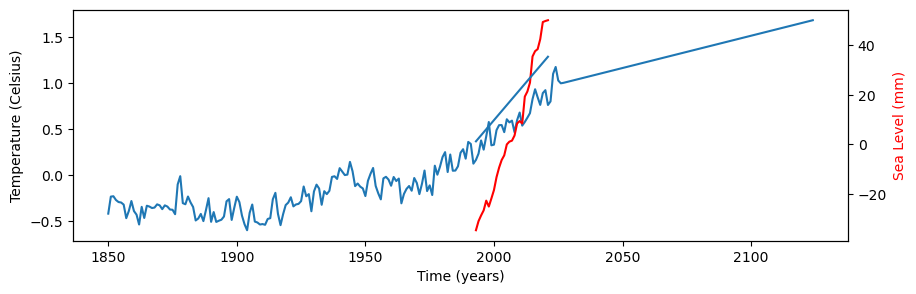

In [279]:
def load_data(base_path = '../data/', plot=False):
    # load data
    df_T_forecast = pd.read_csv(base_path + 'T_forecast_auto_arima.csv', index_col=0)
    df_T = pd.read_csv(base_path + 'processed_temperature_data.csv', index_col=0)
    df_S = pd.read_csv(base_path + 'processed_sea_level_data.csv', index_col=0)

    # stack df_T with forecast
    print('len of df_T', len(df_T))
    print('len of df_T_forecast', len(df_T_forecast))
    df_T = pd.concat([df_T, df_T_forecast])
    df_T_annual = df_T.Annual
    df_T_uncertainty = df_T.Annual_uncertainty
    df_T_annual, df_T_uncertainty

    df_S_annual = df_S.GMSL_noGIA
    df_S_uncertainty = df_S.uncertainty

    if plot:
        # now the data is ready, we will plot

        fig, ax = plt.subplots(figsize=(10, 3))
        ax2 = ax.twinx()

        ax.plot(df_T_annual, label='Temperature')
        ax2.plot(df_S_annual, label='Sea Level', color='red')

        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Temperature (Celsius)')
        ax2.set_ylabel('Sea Level (mm)', color='red')

    return df_T_annual, df_T_uncertainty, df_S_annual, df_S_uncertainty

def align_data(df_T_annual, df_T_uncertainty):
    #df_S_annual  # 1993 : 2021
    #df_T_annual  # 1850 : 2124
    T = df_T_annual.values[143:-103]
    T_unc = df_T_uncertainty.values[143:-103]

    t = df_T_annual.index[143:-103]

    return T, T_unc, t

T, T_unc, S, S_unc = load_data(plot=True)
T, T_unc, t = align_data(T, T_unc)

# scale
S = S *.2
S_unc = S_unc * .2
# try

A_snowfall = 10.1
A_melt = 0.1
rain_constant = 0.1
S0 = 0
C = 0.1
D = 0.1
a = 0.1
b = 0.1
tau = 33.1

S_prediction_0 = glacier_0(T, A_snowfall, A_melt, rain_constant, S0, C, D)
S_prediction_1 = glacier_1(T, A_snowfall, A_melt, rain_constant, S0, C, D)
S_prediction_2 = glacier_2(T, S0, a, b, tau)

plt.plot(t, S_prediction_0, label='glacier_0')
plt.plot(t, S_prediction_1, label='glacier_1')
plt.plot(t, S_prediction_2, label='glacier_2')
plt.legend()
plt.show()

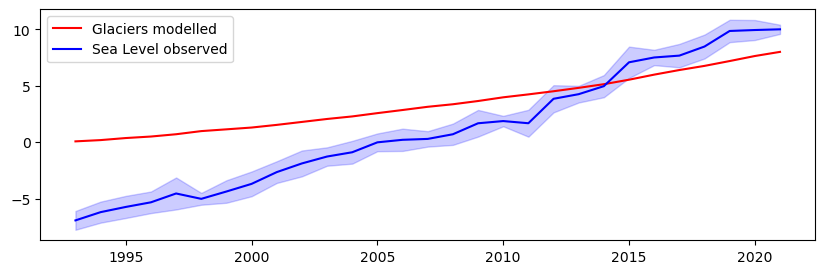

In [280]:
# fit glacier_0
p0 = [10.1, 0.1, 0.1, 0.1, 0.1, 0.1]
popt, pcov = curve_fit(glacier_0, T, S, p0=p0, sigma=S_unc, absolute_sigma=False,
                       bounds=[
                           (-1000, -1000, -1000., 0, 0, 0),
                           (1000, 100000, 1000, 210000, 1, 1)
                       ])

# plot with optimal params
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t, glacier_0(T, *popt), label='Glaciers modelled', color='red')
ax.plot(t, S, label='Sea Level observed', color='blue')
ax.fill_between(t, S-S_unc, S+S_unc, alpha=0.2, color='blue')
ax.legend()
plt.show()


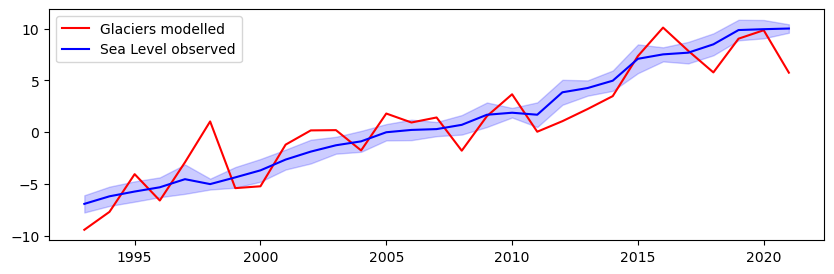

In [284]:
# fit glacier_1
p0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
popt, pcov = curve_fit(glacier_1, T, S, p0=p0, sigma=S_unc, absolute_sigma=False,
                       bounds=[
                           (-1000, -1000, -1000., 0, 0, 0),
                           (1000, 100000, 1000, 210000, 1, 1)
                       ])

# plot with optimal params
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t, glacier_1(T, *popt), label='Glaciers modelled', color='red')
ax.plot(t, S, label='Sea Level observed', color='blue')
ax.fill_between(t, S-S_unc, S+S_unc, alpha=0.2, color='blue')
ax.legend()
plt.show()


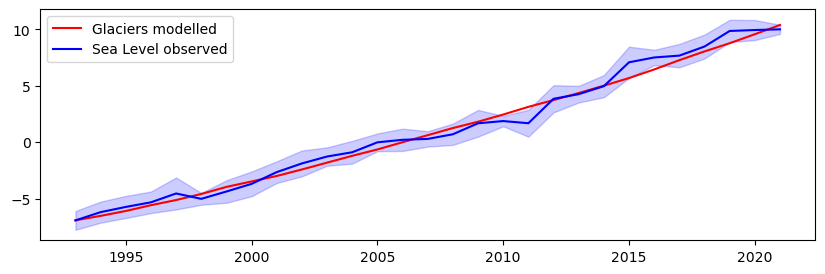

array([  -6.91359606, 1894.88620335,  999.99999997, 3353.79415583])

In [286]:
# fit glacier_2
p0 = [-559, 0.8, 0.8,1,]
popt, pcov = curve_fit(glacier_2, T, S, p0=p0, sigma=S_unc, absolute_sigma=False,
                       bounds=[
                           (-1000, -1000, -1000., 0),
                           (1000, 100000, 1000, 210000)
                       ])

# plot with optimal params
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t, glacier_2(T, *popt), label='Glaciers modelled', color='red')
ax.plot(t, S, label='Sea Level observed', color='blue')
ax.fill_between(t, S-S_unc, S+S_unc, alpha=0.2, color='blue')
ax.legend()
plt.show()

popt

## MCMC

Running burn-in...


100%|██████████| 2000/2000 [01:08<00:00, 29.31it/s]


Running production...


100%|██████████| 10000/10000 [06:16<00:00, 26.59it/s]


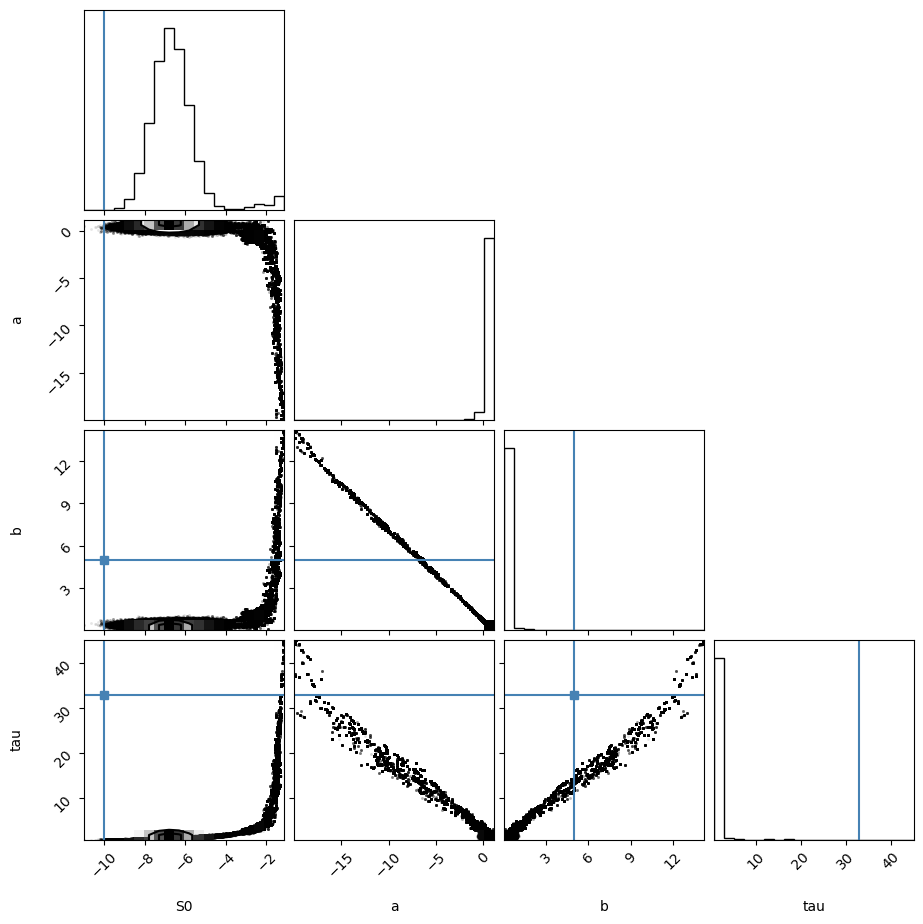

S0 = -6.700 (+0.927, -0.863)
a = 0.524 (+0.228, -0.252)
b = 0.324 (+0.154, -0.139)
tau = 1.037 (+0.190, -0.132)


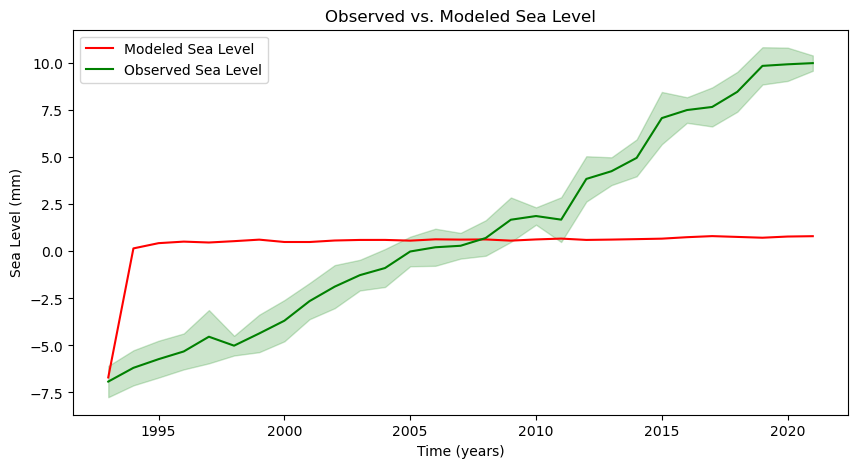

[-6.69988394  0.52365107  0.32443297  1.036956  ]


In [298]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

# Assuming df_T and df_S are already provided as dataframes with relevant temperature and sea level data.
time = t
T = T
T_unc = T_unc

S_obs = S
sigma = S_unc

offset = 100  # Adjust this value as needed

# Define the four-box model (assumed to be provided elsewhere)
def get_dS(T, A_snowfall, A_melt, rain_constant, S0):
    return glacier_2(T, A_snowfall, A_melt, rain_constant, S0)

# Define the log prior function
def log_prior(theta):
    S0, a, b, tau = theta
    if -200 < S0 and S0 < 200 and \
        -20 < a and a < 20 and \
       0 < b and b < 20 and \
       0 < tau and tau < 1000:
    
        return 0.0  # Uniform prior within bounds
    return -np.inf  # Outside the bounds, log probability is negative infinity

# Define the log likelihood function
def log_likelihood(theta, T, S_obs, sigma):
    A_snowfall, A_melt, rain_constant, S0= theta
    dS = get_dS(T, A_snowfall, A_melt, rain_constant, S0)
    
    if np.any(np.isnan(dS)) or np.any(np.isinf(dS)):
        return -np.inf
    
    S_model = np.cumsum(dS)
    
    residuals = (S_obs - S_model) / sigma
    log_likelihood_val = -0.5 * np.sum(residuals**2 + np.log(2 * np.pi * sigma**2))
    
    if np.isnan(log_likelihood_val) or np.isinf(log_likelihood_val):
        return -np.inf
    
    return log_likelihood_val

# Define the full log probability function
def log_probability(theta, T, S_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T, S_obs, sigma)

# Initial guess for the parameters
# array([  -6.91359606, 1894.88620335,  999.99999997, 3353.79415583])
initial_params = [-10, 10,  5, 33]
ndim = len(initial_params)  # Number of parameters
nwalkers = 256  # Number of walkers for MCMC

# Initialize walkers in a Gaussian ball around the initial guess
pos = initial_params + 1e-1 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(T, S_obs, sigma))

# Burn-in phase
print("Running burn-in...")
sampler.run_mcmc(pos, 2000, progress=True)
sampler.reset()

# Production run
print("Running production...")
sampler.run_mcmc(None, 10000, progress=True)

# Extract the samples
samples = sampler.get_chain(flat=True)

# Plot posterior distributions using the corner library
fig = corner.corner(samples, labels=["S0", "a", "b", "tau"], truths=initial_params)
plt.show()

# Compute the mean and uncertainties of the parameters
param_names = ["S0", "a", "b", "tau"]
for i, name in enumerate(param_names):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")

# Use the median parameters to compute the modeled sea level
best_params = np.median(samples, axis=0)
S_model_full = get_dS(T, *best_params)

# Plot the observed vs. modeled sea level
plt.figure(figsize=(10, 5))
plt.plot(time, S_model_full, label='Modeled Sea Level', color='red')
plt.plot(time, S_obs, label='Observed Sea Level', color='green')

# Add uncertainty bounds
plt.fill_between(time, S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)

plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()


popt = best_params

print(popt)

